In [2]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [6]:
import pandas as pd

file_path = '/content/train.csv'

df = pd.read_csv(file_path)

### **1. Understanding Dataset**

In [3]:
print("DataFrame Shape (Rows, Columns):", df.shape)

DataFrame Shape (Rows, Columns): (15533, 18)


In [5]:
print("\nData Types (df.info()):")
df.info()


Data Types (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  int64  
 1   Gender                          15533 non-null  object 
 2   Age                             15533 non-null  float64
 3   Height                          15533 non-null  float64
 4   Weight                          15533 non-null  float64
 5   family_history_with_overweight  15533 non-null  object 
 6   FAVC                            15533 non-null  object 
 7   FCVC                            15533 non-null  float64
 8   NCP                             15533 non-null  float64
 9   CAEC                            15533 non-null  object 
 10  SMOKE                           15533 non-null  object 
 11  CH2O                            15533 non-null  float64
 12  SCC    

**1.1 Missing values and duplicates**

In [6]:
df.isnull().sum().sort_values(ascending=False)
df.duplicated().sum()

np.int64(0)

 The dataset is complete as no missing values and duplicate rows were detected, ensuring a clean foundation for analysis and modeling.

In [7]:
print("\nFirst 5 Rows of the DataFrame (df.head()):")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))


First 5 Rows of the DataFrame (df.head()):
| id   | Gender   | Age     | Height   | Weight   | family_history_with_overweight   | FAVC   | FCVC    | NCP     | CAEC       | SMOKE   | CH2O    | SCC   | FAF      | TUE      | CALC      | MTRANS                | WeightCategory      |
|:-----|:---------|:--------|:---------|:---------|:---------------------------------|:-------|:--------|:--------|:-----------|:--------|:--------|:------|:---------|:---------|:----------|:----------------------|:--------------------|
| 0    | Male     | 24.443  | 1.7      | 81.67    | yes                              | yes    | 2       | 2.9833  | Sometimes  | no      | 2.76357 | no    | 0        | 0.976473 | Sometimes | Public_Transportation | Overweight_Level_II |
| 1    | Female   | 18      | 1.56     | 57       | yes                              | yes    | 2       | 3       | Frequently | no      | 2       | no    | 1        | 1        | no        | Automobile            | Normal_Weight       |
| 2    |

**1.2 Variable Identification**

In [12]:
# Target is 'WeightCategory'
TARGET_VARIABLE = 'WeightCategory'
FEATURE_VARIABLES = df.columns.drop(['id', TARGET_VARIABLE]).tolist()

print("\n--- Variable Identification ---")
print(f"Target Variable: {TARGET_VARIABLE}")
print(f"Feature Variables (excluding 'id'): {len(FEATURE_VARIABLES)} columns")


--- Variable Identification ---
Target Variable: WeightCategory
Feature Variables (excluding 'id'): 16 columns


**1.3 Target Class Distribution**

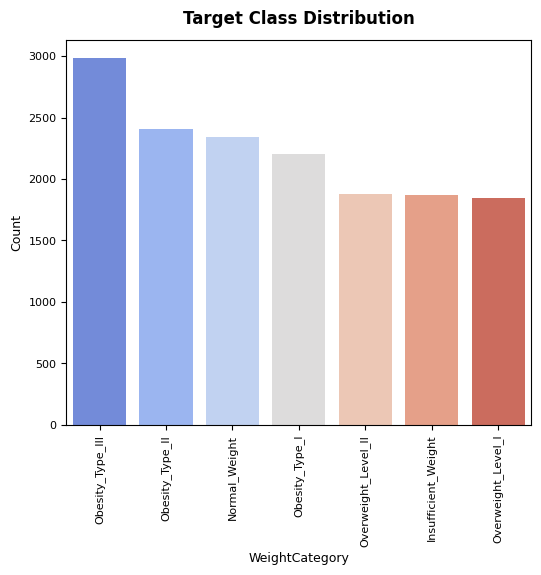

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

categories = df['WeightCategory'].value_counts().index
colors = sns.color_palette("coolwarm", len(categories))

plt.figure(figsize=(6, 5))
sns.countplot(
    x='WeightCategory',
    hue='WeightCategory',
    data=df,
    order=categories,
    palette=dict(zip(categories, colors))
)

plt.title('Target Class Distribution', fontsize=12, fontweight='bold', y=1.02)
plt.xticks(rotation=90)
plt.xlabel('WeightCategory', fontsize=9)
plt.ylabel('Count', fontsize=9)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.show()

### **2. Exploratory Data Analysis**

**2.1 Feature Analysis**

In [13]:
# explicitly list the numericals and categoricals (excluding 'id' and 'WeightCategory')
df_temp = df.drop(columns=['id', TARGET_VARIABLE], errors='ignore')
numerical_cols = df_temp.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_temp.select_dtypes(include=['object']).columns.tolist()

In [11]:
from tabulate import tabulate
import pandas as pd

# Create a DataFrame with aligned columns
max_len = max(len(numerical_cols), len(categorical_cols))
numerical_cols += [''] * (max_len - len(numerical_cols))
categorical_cols += [''] * (max_len - len(categorical_cols))

table_df = pd.DataFrame({
    'Numerical Columns': numerical_cols,
    'Categorical Columns': categorical_cols
})

# Print as formatted table
print(tabulate(table_df, headers='keys', tablefmt='grid'))

+----+---------------------+--------------------------------+
|    | Numerical Columns   | Categorical Columns            |
+====+=====================+================================+
|  0 | Age                 | Gender                         |
+----+---------------------+--------------------------------+
|  1 | Height              | family_history_with_overweight |
+----+---------------------+--------------------------------+
|  2 | Weight              | FAVC                           |
+----+---------------------+--------------------------------+
|  3 | FCVC                | CAEC                           |
+----+---------------------+--------------------------------+
|  4 | NCP                 | SMOKE                          |
+----+---------------------+--------------------------------+
|  5 | CH2O                | SCC                            |
+----+---------------------+--------------------------------+
|  6 | FAF                 | CALC                           |
+----+--

**2.2 Numerical Feature Analysis**

**2.2.1 Descriptive Stats**

In [12]:

print("\n\n" + "="*80)
print("                          Descriptive Statistics")
print("="*80)

# Calculate and print descriptive statistics, transposed for better readability
numerical_stats = df[numerical_cols].describe().T
print(numerical_stats.to_markdown(numalign="left", stralign="left"))




                          Descriptive Statistics
|        | count   | mean     | std      | min   | 25%     | 50%      | 75%     | max     |
|:-------|:--------|:---------|:---------|:------|:--------|:---------|:--------|:--------|
| Age    | 15533   | 23.8163  | 5.66317  | 14    | 20      | 22.7716  | 26      | 61      |
| Height | 15533   | 1.69992  | 0.08767  | 1.45  | 1.63093 | 1.7      | 1.76292 | 1.97566 |
| Weight | 15533   | 87.7852  | 26.3691  | 39    | 66      | 84       | 111.601 | 165.057 |
| FCVC   | 15533   | 2.44292  | 0.530895 | 1     | 2       | 2.34222  | 3       | 3       |
| NCP    | 15533   | 2.76042  | 0.706463 | 1     | 3       | 3        | 3       | 4       |
| CH2O   | 15533   | 2.02763  | 0.607733 | 1     | 1.79626 | 2        | 2.53146 | 3       |
| FAF    | 15533   | 0.976968 | 0.836841 | 0     | 0.00705 | 1        | 1.58268 | 3       |
| TUE    | 15533   | 0.613813 | 0.602223 | 0     | 0       | 0.566353 | 1       | 2       |


**2.2.2 Univariate Analysis**

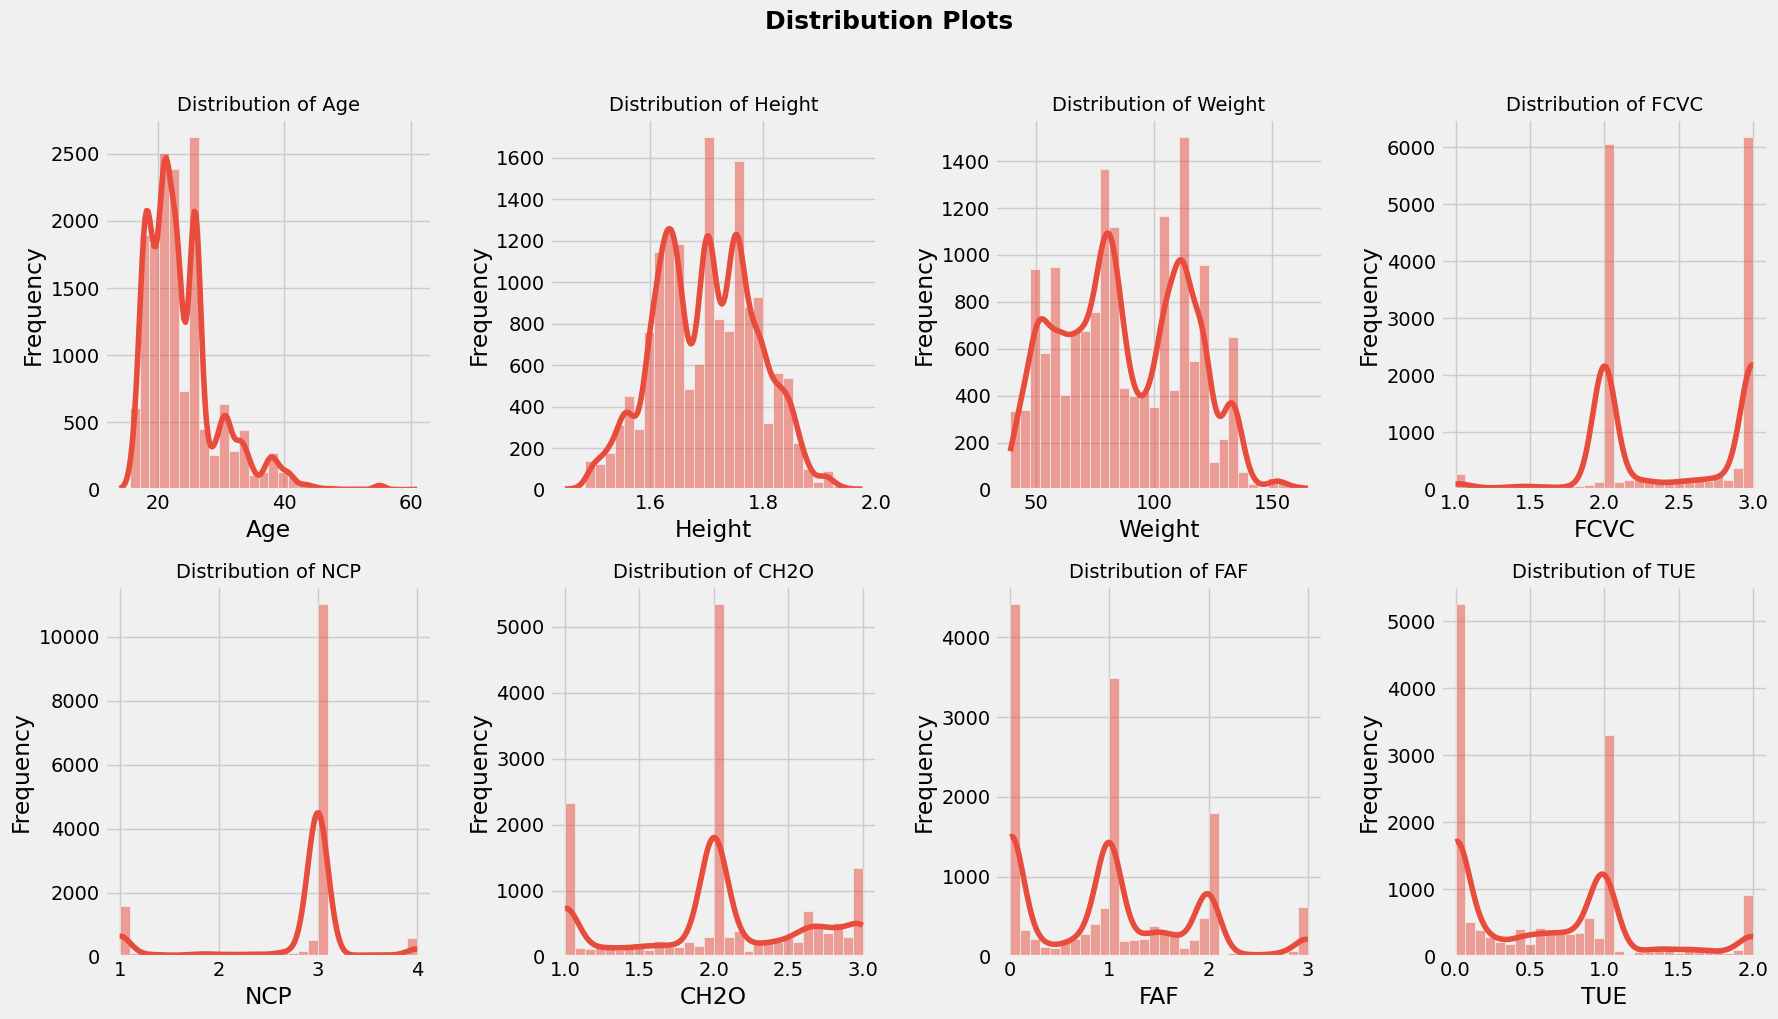

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

n_cols = 4
n_rows = -(-len(numerical_cols) // n_cols)  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    sns.histplot(df[col], kde=True, bins=30, ax=ax, color='#e74c3c')
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution Plots", fontsize=18, fontweight='bold', y=1.02)  # Add figure-level title
plt.tight_layout()
plt.show()

The numerical features exhibit diverse distributions—some are symmetric (e.g., Height, CH2O), while others show skewness or multimodality (e.g., Age, FAF), indicating varied behavioral and physiological patterns across the dataset.

**2.2.3 Bivariate Analysis**

**2.2.3.2 Numerical Feature Distribution vs WeightCategory**

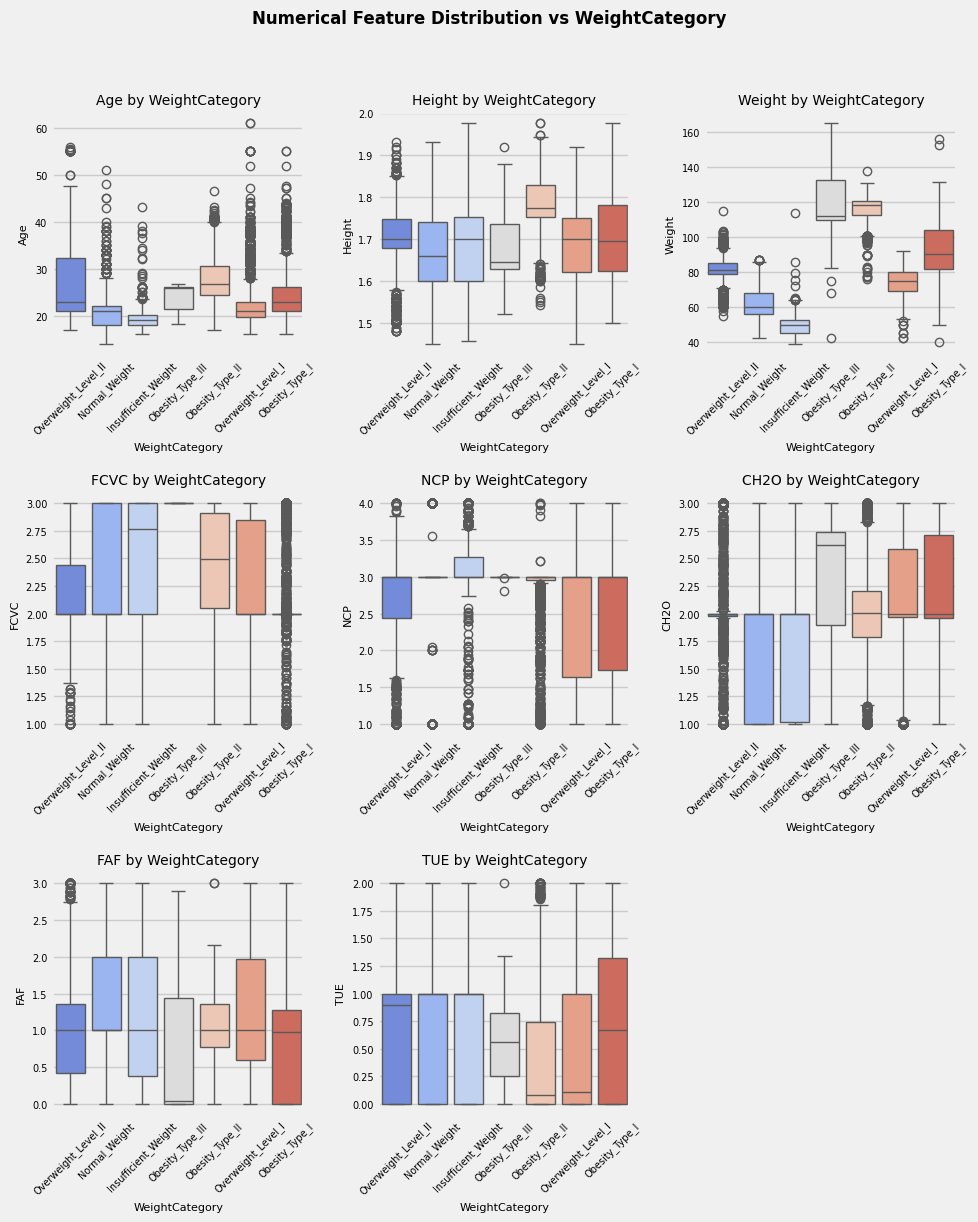

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

target = 'WeightCategory'

numerical_cols = df.select_dtypes(include='number').drop(columns=['id']).columns

n_cols = 3
n_rows = -(-len(numerical_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4* n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[target], y=df[col], ax=axes[i], hue=df[target], palette='coolwarm', dodge=False)
    axes[i].set_title(f'{col} by {target}', fontsize=10)
    axes[i].set_xlabel(target, fontsize=8)
    axes[i].set_ylabel(col, fontsize=8)
    axes[i].tick_params(axis='x', labelsize=7, rotation=45)
    axes[i].tick_params(axis='y', labelsize=7)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Numerical Feature Distribution vs WeightCategory", fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

The heatmap reveals moderate correlations among lifestyle and biometric variables, with notable links like Height–Weight and FCVC–NCP, aiding feature selection and pattern discovery.

**2.3 Categorical Feature Analysis**

**2.3.1 Univariate Analysis**

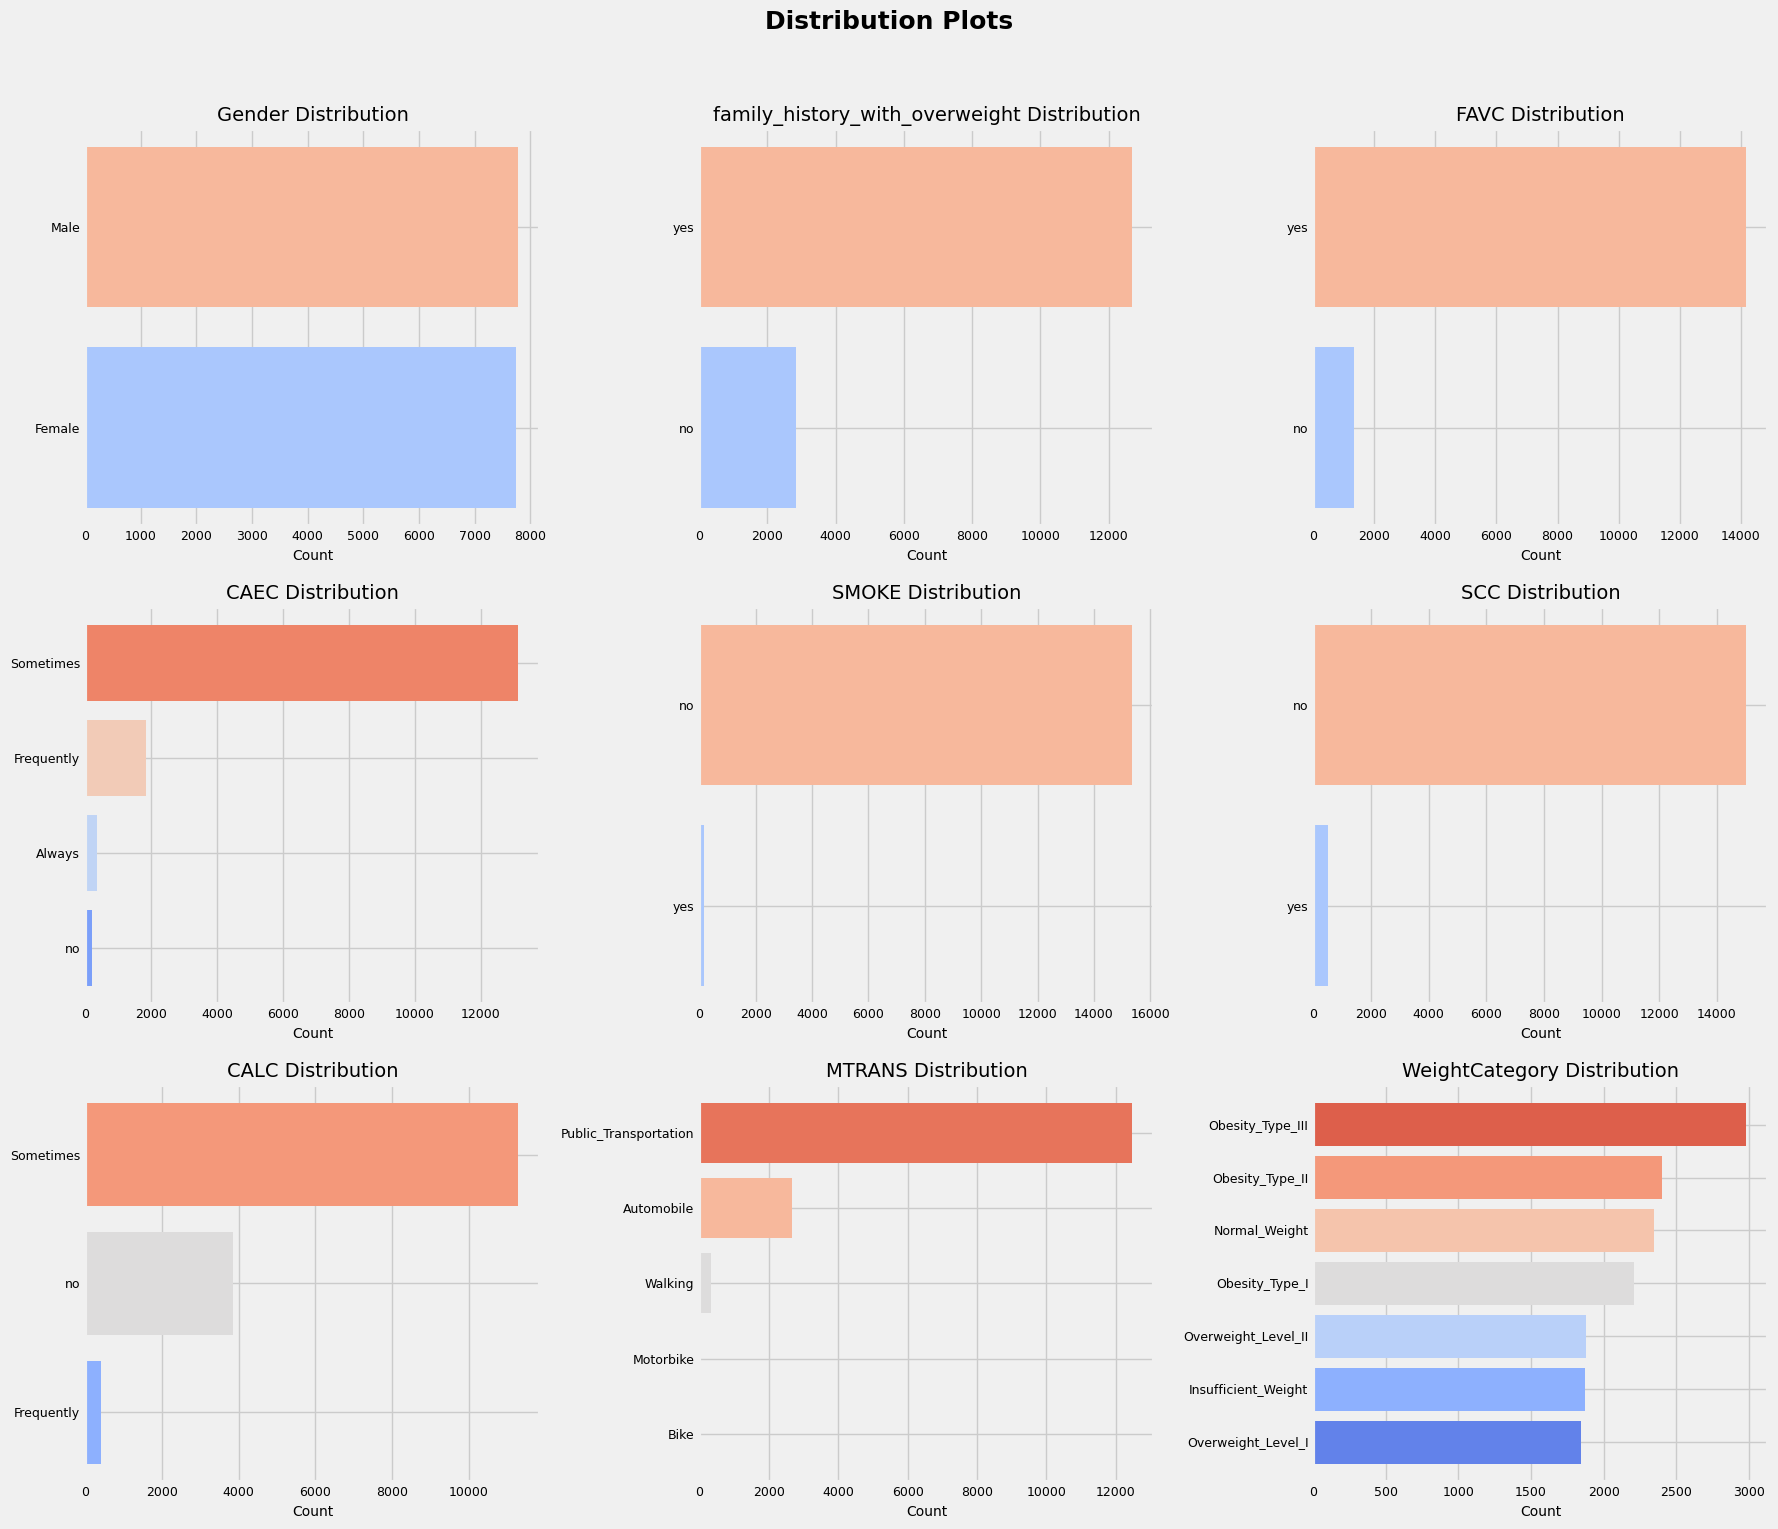

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = df.select_dtypes(include='object').columns

n_cols = 3
n_rows = -(-len(categorical_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    counts = df[col].value_counts()
    labels = counts.index
    values = counts.values

    # Generate coolwarm shades based on number of categories
    bar_colors = sns.color_palette("coolwarm", len(labels))[::-1]

    # Horizontal bar plot
    ax.barh(labels, values, color=bar_colors)
    ax.set_title(f'{col} Distribution', fontsize=14)
    ax.set_xlabel('Count', fontsize=10)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.invert_yaxis()  # Highest count on top

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution Plots", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**2.3.2 Bivariate Analysis**

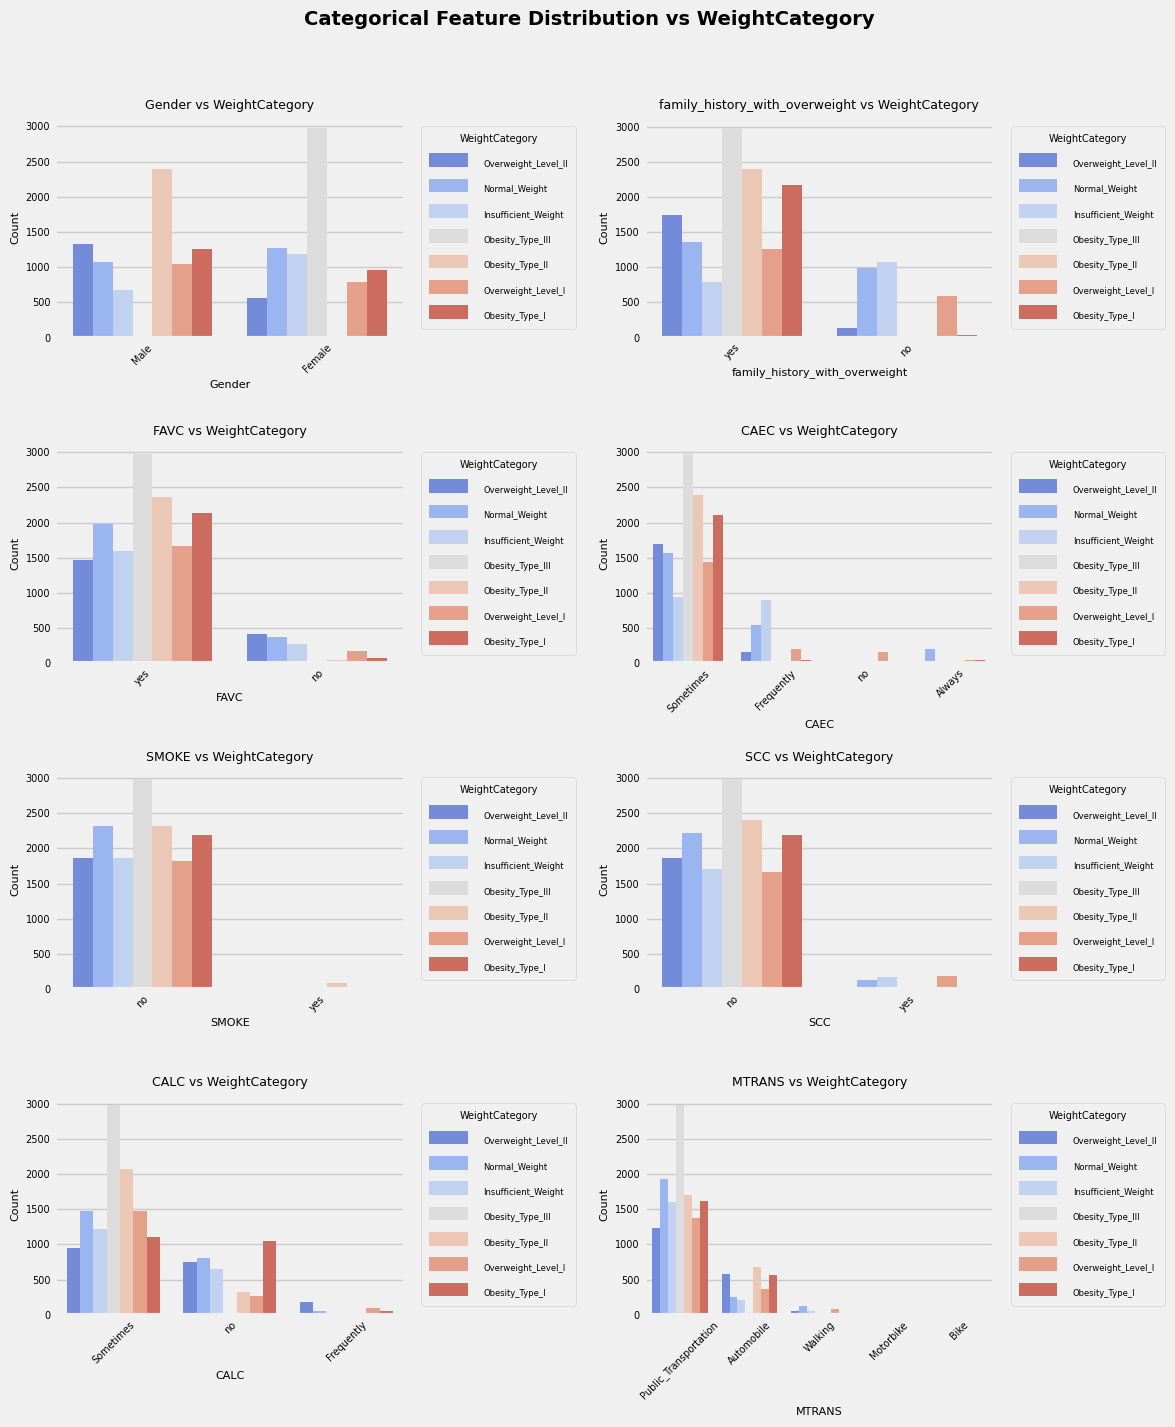

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define your categorical target
target = 'WeightCategory'

# Select all categorical columns except the target
categorical_cols = df.select_dtypes(include='object').drop(columns=[target]).columns

# Layout: 2 plots per row
n_cols = 2
n_rows = -(-len(categorical_cols) // n_cols)  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5 * n_rows))  # Smaller figure size
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, hue=target, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'{col} vs {target}', fontsize=9)  # Reduced title font size
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Count', fontsize=8)
    axes[i].tick_params(axis='x', labelsize=7, rotation=45)
    axes[i].tick_params(axis='y', labelsize=7)

    # Move legend to the right and shrink font
    legend = axes[i].legend(title=target, loc='center left', bbox_to_anchor=(1.02, 0.5))
    legend.set_title(target, prop={'size': 7})
    for text in legend.get_texts():
        text.set_fontsize(6)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Categorical Feature Distribution vs WeightCategory", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

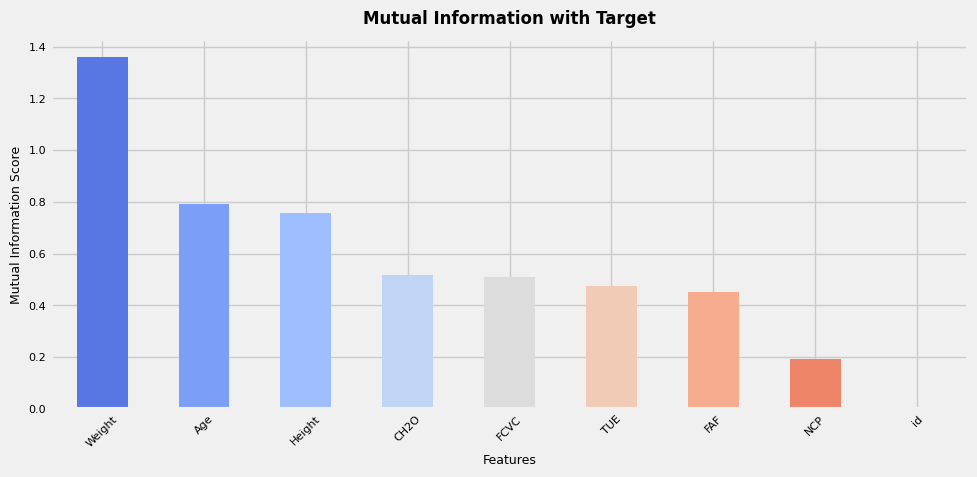

In [17]:
#Mutual Information with Target
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection
X = df.drop('WeightCategory', axis=1)
y = df['WeightCategory']
mi = mutual_info_classif(X.select_dtypes('number'), y)

# Create Series and sort
mi_df = pd.Series(mi, index=X.select_dtypes('number').columns).sort_values(ascending=False)

# Generate coolwarm color palette
colors = sns.color_palette("coolwarm", len(mi_df))

# Plot with reduced font sizes
ax = mi_df.plot.bar(
    figsize=(10, 5),
    color=colors
)
ax.set_xlabel("Features", fontsize=9)
ax.set_ylabel("Mutual Information Score", fontsize=9)
ax.tick_params(axis='x', labelsize=8, rotation=45)
ax.tick_params(axis='y', labelsize=8)
plt.title("Mutual Information with Target",fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

The above graph highlights that Weight, Age, and Height are the most informative features for predicting the target variable. Features like Id and MTRANS offer minimal predictive value

**2.4 Correlation Heatmap**

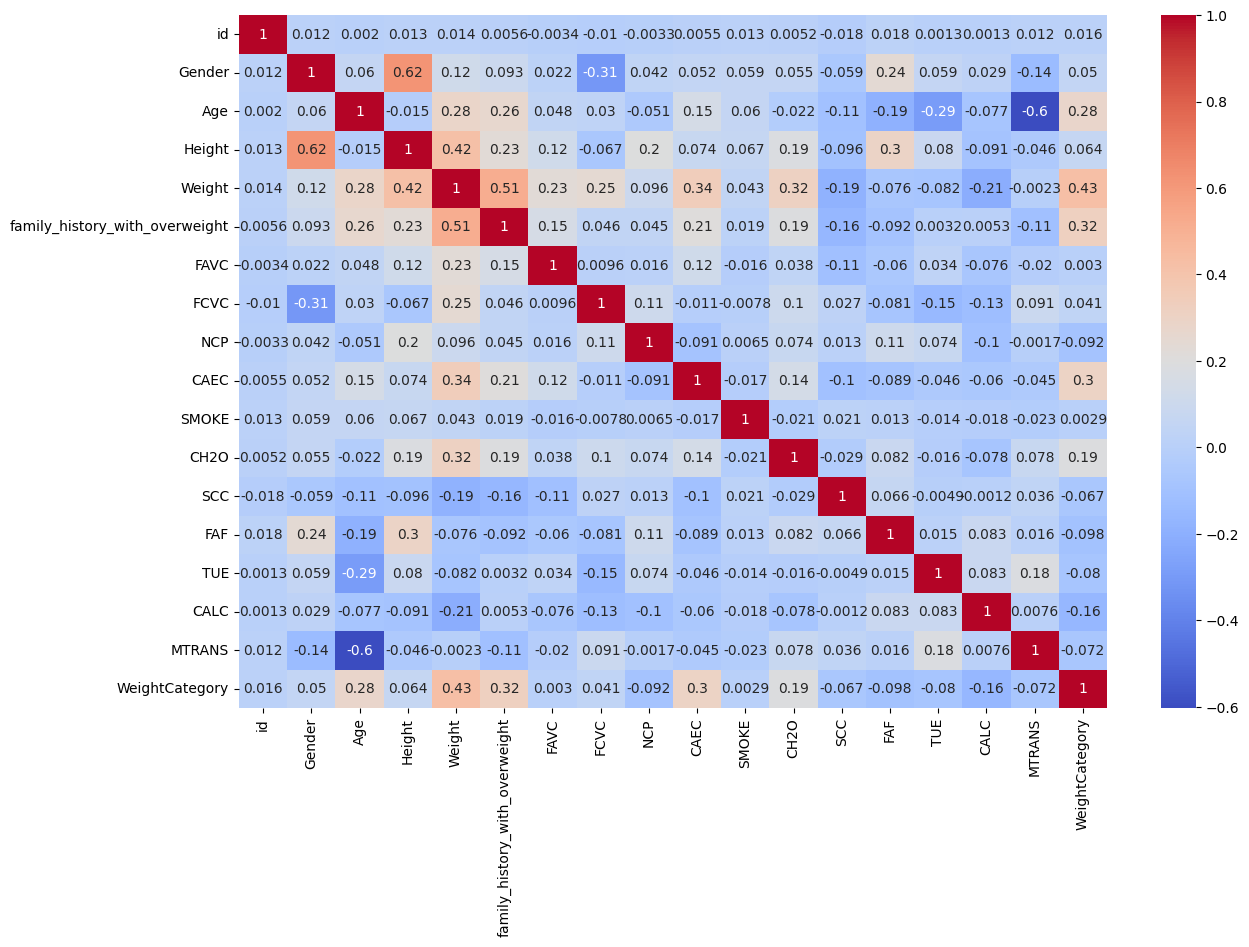

In [21]:
df_copy = df.copy()
categorical_cols = df_copy.select_dtypes(include='object').columns

for col in categorical_cols:
    df_copy[col] = LabelEncoder().fit_transform(df_copy[col])

plt.figure(figsize=(14,9))
sns.heatmap(df_copy.corr(), annot=True, cmap='coolwarm')
plt.show()

**2.5 Outlier Analysis**

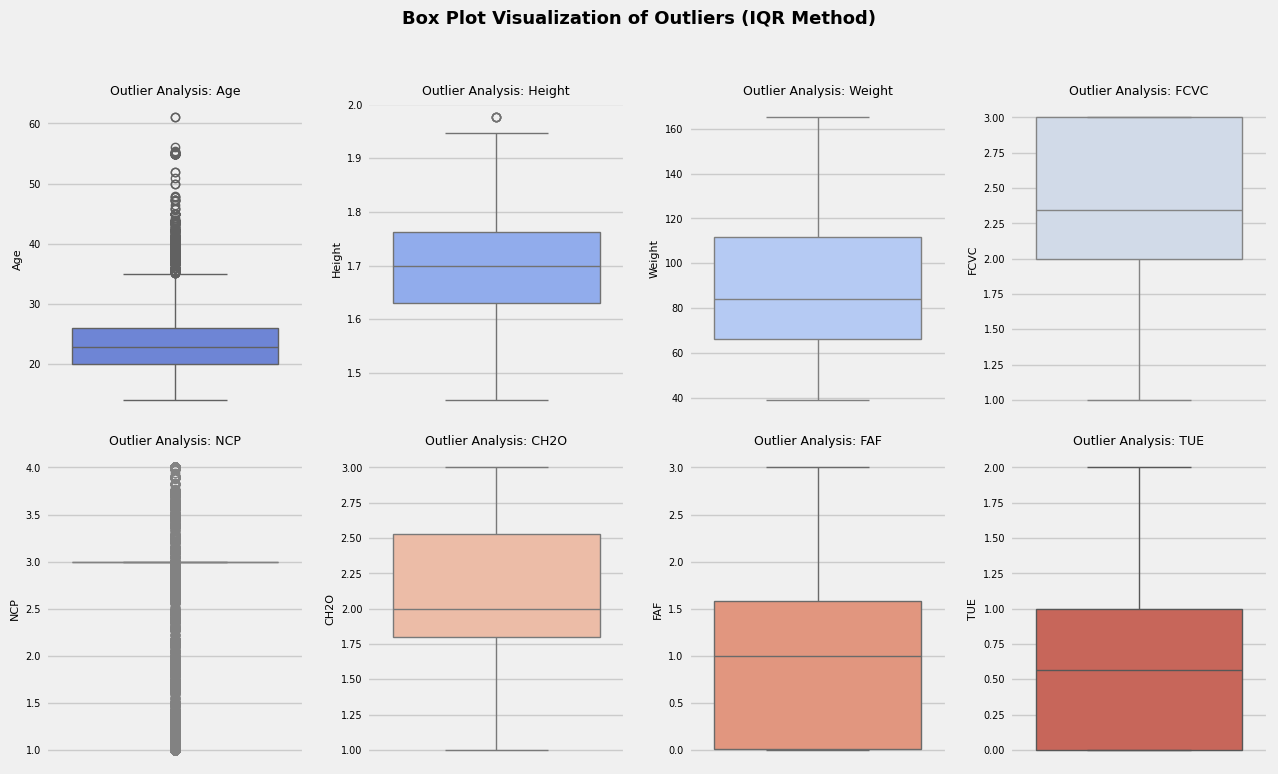

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop 'id' column if present
df_clean = df.drop(columns=['id'], errors='ignore')

# Select numerical columns
numerical_cols = df_clean.select_dtypes(include='number').columns

# Layout: 2 rows max
n_rows = min(2, -(-len(numerical_cols) // 2))  # Max 2 rows
n_cols = -(-len(numerical_cols) // n_rows)     # Adjust columns accordingly

# Generate color palette
colors = sns.color_palette("coolwarm", len(numerical_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 3.8 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df_clean[col], ax=axes[i], color=colors[i])
    axes[i].set_title(f'Outlier Analysis: {col}', fontsize=9)
    axes[i].set_ylabel(col, fontsize=8)
    axes[i].tick_params(axis='y', labelsize=7)
    axes[i].tick_params(axis='x', labelsize=7)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Box Plot Visualization of Outliers (IQR Method)", fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

The box plots reveal that Age, FAF, and TUE have significant outliers and skewed distributions, suggesting the need for transformation. In contrast, features like FCVC and CH2O are tightly clustered, indicating consistent behavior across individuals.

### **3. Data Preprocessing**

In [20]:
df.isnull().any()

,0
id,False
Gender,False
Age,False
Height,False
Weight,False
family_history_with_overweight,False
FAVC,False
FCVC,False
NCP,False
CAEC,False


In [21]:
df.duplicated().any()

np.False_

In [14]:
x=df.drop('WeightCategory',axis=1)
target=df["WeightCategory"]
target.head()

,WeightCategory
0,Overweight_Level_II
1,Normal_Weight
2,Insufficient_Weight
3,Obesity_Type_III
4,Overweight_Level_II


In [15]:
numeric_cols = x.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = x.select_dtypes(include=['object', 'category']).columns.tolist()
from sklearn.preprocessing import OneHotEncoder
X_encoded = pd.get_dummies(x, drop_first=True)  # simple one-hot encoding

**Loading Dataset**

In [22]:
trainData = pd.read_csv("/content/train.csv")
testData = pd.read_csv("/content/test.csv")

X = trainData.drop(columns=['WeightCategory', 'id'])
y = trainData['WeightCategory']

X_test = testData.drop(columns=['id'])

In [23]:
cat_cols = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']
le = LabelEncoder()
for col in cat_cols:
    x[col] = le.fit_transform(x[col])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

**3.1 Decision Tree**

In [27]:
dt_clf = DecisionTreeClassifier(random_state=42)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

dt_clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

test_accuracy_dtt = accuracy_score(y_test, y_pred)
test_precision_dtt = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall_dtt = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1_dtt = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\n" + "-"*40)
print(" Decision Tree Model Evaluation")
print("-"*40)
print(f" Test Accuracy           : {test_accuracy_dtt:.4f}")
print(f" Precision (Weighted)    : {test_precision_dtt:.4f}")
print(f" Recall (Weighted)       : {test_recall_dtt:.4f}")
print(f" F1-Score (Weighted)     : {test_f1_dtt:.4f}")
print("-"*40)

print("\n" + "="*40)
print(" Confusion Matrix")
print("="*40)
cm = confusion_matrix(y_test, y_pred)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*40)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importances
importances = dt_clf.feature_importances_
feature_names = X_train.columns

feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n Feature Importances:")
print(feat_importances.to_string(index=False))



----------------------------------------
 Decision Tree Model Evaluation
----------------------------------------
 Test Accuracy           : 0.8651
 Precision (Weighted)    : 0.8659
 Recall (Weighted)       : 0.8651
 F1-Score (Weighted)     : 0.8655
----------------------------------------

 Confusion Matrix
│  307    36     1     1     0     0     1 │
│   29   413     1     0     0    50     3 │
│    0     0   393    15     1    10    29 │
│    0     0    26   436     0     0     2 │
│    0     0     3     1   602     0     0 │
│    3    49     8     0     0   268    56 │
│    0     6    27     1     0    60   269 │

 Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.89      0.90       346
      Normal_Weight       0.82      0.83      0.83       496
     Obesity_Type_I       0.86      0.88      0.87       448
    Obesity_Type_II       0.96      0.94      0.95       464
   Obesity_Type_III       1.00      0.99   

Accuracy with decision tree is 0.8651

**Hyperparameter Tuning Using Optuna on Decision Tree**

In [26]:
pip install optuna

In [29]:
import optuna

def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    dt_clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    score = cross_val_score(dt_clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
dt_clf_best = DecisionTreeClassifier(**best_params, random_state=42)
dt_clf_best.fit(X_train, y_train)
y_pred = dt_clf_best.predict(X_test)

test_accuracy_dtt_hp = accuracy_score(y_test, y_pred)
test_precision_dtt_hp = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall_dtt_hp = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1_dtt_hp = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Best parameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)

print(" Decision Tree Model Evaluation")
print("-"*40)
print(f" Test Accuracy           : {test_accuracy_dtt_hp:.4f}")
print(f" Precision (Weighted)    : {test_precision_dtt_hp:.4f}")
print(f" Recall (Weighted)       : {test_recall_dtt_hp:.4f}")
print(f" F1-Score (Weighted)     : {test_f1_dtt_hp:.4f}")
print("-"*40)

print("\n" + "="*40)
print(" Confusion Matrix")
print("="*40)
cm = confusion_matrix(y_test, y_pred)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*40)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importances
importances = dt_clf.feature_importances_
feature_names = X_train.columns

feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n Feature Importances:")
print(feat_importances.to_string(index=False))



[I 2025-10-28 08:26:13,340] A new study created in memory with name: no-name-aece64dc-5d41-448a-9b27-5b2306620e33


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-28 08:26:14,160] Trial 0 finished with value: 0.8682603100501641 and parameters: {'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8682603100501641.
[I 2025-10-28 08:26:15,062] Trial 1 finished with value: 0.8677774450403144 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8682603100501641.
[I 2025-10-28 08:26:15,724] Trial 2 finished with value: 0.8536131349642504 and parameters: {'criterion': 'log_loss', 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8682603100501641.
[I 2025-10-28 08:26:16,187] Trial 3 finished with value: 0.8685826301331723 and parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8685826301331723.
[I 2025-10-28 08:26:16,667] Trial 4 finished with value: 0.8686631777794684 and par

Accuracy with decision tree using optuna is 0.8713

**3.2 Random Forest**

In [30]:

rf_clf = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

test_accuracy_rf = accuracy_score(y_test, y_pred)
test_precision_rf = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall_rf = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1_rf = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\n" + "-"*45)
print(" Random Forest Model Evaluation")
print("-"*45)
print(f" Test Accuracy           : {test_accuracy_rf:.4f}")
print(f" Precision (Weighted)    : {test_precision_rf:.4f}")
print(f" Recall (Weighted)       : {test_recall_rf:.4f}")
print(f" F1-Score (Weighted)     : {test_f1_rf:.4f}")
print("-"*45)

print("\n" + "="*45)
print(" Confusion Matrix")
print("="*45)
cm = confusion_matrix(y_test, y_pred)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*45)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importances
importances = rf_clf.feature_importances_
feature_names = X_train.columns

feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n Feature Importances:")
print(feat_importances.to_string(index=False))




---------------------------------------------
 Random Forest Model Evaluation
---------------------------------------------
 Test Accuracy           : 0.8919
 Precision (Weighted)    : 0.8935
 Recall (Weighted)       : 0.8919
 F1-Score (Weighted)     : 0.8915
---------------------------------------------

 Confusion Matrix
│  308    35     0     1     0     1     1 │
│   19   441     1     0     0    28     7 │
│    0     1   395    13     1    10    28 │
│    0     0    12   449     0     0     3 │
│    0     0     1     1   603     1     0 │
│    2    51     8     0     0   267    56 │
│    0    12    20     1     0    22   308 │

 Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.89      0.91       346
      Normal_Weight       0.82      0.89      0.85       496
     Obesity_Type_I       0.90      0.88      0.89       448
    Obesity_Type_II       0.97      0.97      0.97       464
   Obesity_Type_III       1.

The accuracy from Random Forest is 0.8919

**Hyperparameter Tuning Using Optuna On Random Forest**

In [31]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])

    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
rf_clf_best = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_clf_best.fit(X_train, y_train)
y_pred = rf_clf_best.predict(X_test)

test_accuracy_rf_hp = accuracy_score(y_test, y_pred)
test_precision_rf_hp = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall_rf_hp = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1_rf_hp = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Best parameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)
print("\n" + "-"*50)
print(" Random Forest Model Evaluation (Optimized)")
print("-"*50)
print(f" Test Accuracy           : {test_accuracy_rf_hp:.4f}")
print(f" Precision (Weighted)    : {test_precision_rf_hp:.4f}")
print(f" Recall (Weighted)       : {test_recall_rf_hp:.4f}")
print(f" F1-Score (Weighted)     : {test_f1_rf_hp:.4f}")
print("-"*50)

print("\n" + "="*50)
print(" Confusion Matrix")
print("="*50)
cm = confusion_matrix(y_test, y_pred)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*50)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importances
importances = rf_clf_best.feature_importances_
feature_names = X_train.columns

feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n Feature Importances (Sorted):")
print(feat_importances.to_string(index=False))

[I 2025-10-28 08:30:05,795] A new study created in memory with name: no-name-c73951ec-421f-4d1b-af6f-216d83759c70


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-28 08:31:53,462] Trial 0 finished with value: 0.8896667211636675 and parameters: {'n_estimators': 480, 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.8896667211636675.
[I 2025-10-28 08:32:17,471] Trial 1 finished with value: 0.8549818622110783 and parameters: {'n_estimators': 370, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.8896667211636675.
[I 2025-10-28 08:32:29,871] Trial 2 finished with value: 0.7904404059109282 and parameters: {'n_estimators': 251, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'log_loss'}. Best is trial 0 with value: 0.8896667211636675.
[I 2025-10-28 08:33:07,385] Trial 3 finished with value: 0.889586270640739 and parameters: {'n_estimators': 138, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 5, '

The accuracy from Random Forest using optuna is 0.8970

**3.3 GRADIENT BOOSTING**

In [33]:
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)

gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)

test_accuracy_gb = accuracy_score(y_test, y_pred)
test_precision_gb = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall_gb = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1_gb = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\n" + "-"*50)
print(" Gradient Boosting Model Evaluation")
print("-"*50)
print(f" Test Accuracy           : {test_accuracy_gb:.4f}")
print(f" Precision (Weighted)    : {test_precision_gb:.4f}")
print(f" Recall (Weighted)       : {test_recall_gb:.4f}")
print(f" F1-Score (Weighted)     : {test_f1_gb:.4f}")
print("-"*50)

print("\n" + "="*50)
print(" Confusion Matrix")
print("="*50)
cm = confusion_matrix(y_test, y_pred)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*50)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importances
importances = gb_clf.feature_importances_
feature_names = X_train.columns

feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n Feature Importances (Sorted):")
print(feat_importances.to_string(index=False))



--------------------------------------------------
 Gradient Boosting Model Evaluation
--------------------------------------------------
 Test Accuracy           : 0.8980
 Precision (Weighted)    : 0.8982
 Recall (Weighted)       : 0.8980
 F1-Score (Weighted)     : 0.8981
--------------------------------------------------

 Confusion Matrix
│  312    31     1     1     0     0     1 │
│   25   432     2     0     0    34     3 │
│    1     0   397    11     1    12    26 │
│    0     0    16   448     0     0     0 │
│    0     0     2     1   603     0     0 │
│    2    34     6     0     0   299    43 │
│    0     7    21     3     0    33   299 │

 Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.90      0.91       346
      Normal_Weight       0.86      0.87      0.86       496
     Obesity_Type_I       0.89      0.89      0.89       448
    Obesity_Type_II       0.97      0.97      0.97       464
   Obesit

The accuracy using Gradient Boosting is 0.8980

In [34]:
pip install xgboost

**3.4 XGBOOST**

In [36]:
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    x, y_enc, test_size=0.2, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_clf.fit(X_train, y_train)

y_pred_enc = xgb_clf.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test)

test_accuracy_xgb = accuracy_score(y_test_orig, y_pred)
test_precision_xgb = precision_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_recall_xgb = recall_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_f1_xgb = f1_score(y_test_orig, y_pred, average='weighted', zero_division=0)

print("\n" + "-"*50)
print(" XGBoost Model Evaluation")
print("-"*50)
print(f" Test Accuracy           : {test_accuracy_xgb:.4f}")
print(f" Precision (Weighted)    : {test_precision_xgb:.4f}")
print(f" Recall (Weighted)       : {test_recall_xgb:.4f}")
print(f" F1-Score (Weighted)     : {test_f1_xgb:.4f}")
print("-"*50)

print("\n" + "="*50)
print(" Confusion Matrix")
print("="*50)
cm = confusion_matrix(y_test_orig, y_pred)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*50)

print("\n Classification Report:")
print(classification_report(y_test_orig, y_pred))

# Feature Importances
importances = xgb_clf.feature_importances_
feature_names = X_train.columns

feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n Feature Importances (Sorted):")
print(feat_importances.to_string(index=False))



--------------------------------------------------
 XGBoost Model Evaluation
--------------------------------------------------
 Test Accuracy           : 0.9034
 Precision (Weighted)    : 0.9040
 Recall (Weighted)       : 0.9034
 F1-Score (Weighted)     : 0.9036
--------------------------------------------------

 Confusion Matrix
│  313    30     1     1     0     0     1 │
│   19   435     2     0     0    35     5 │
│    0     0   403    10     1    12    22 │
│    0     0    11   452     0     0     1 │
│    0     0     1     1   603     0     1 │
│    2    33     4     0     0   301    44 │
│    0     7    22     1     0    33   300 │

 Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.90      0.92       346
      Normal_Weight       0.86      0.88      0.87       496
     Obesity_Type_I       0.91      0.90      0.90       448
    Obesity_Type_II       0.97      0.97      0.97       464
   Obesity_Type_III

The accuracy using xgboost is 0.9034

**Hyperparameter Tuning Using Optuna On XGBoost**

In [37]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Separate features and target
X = train_df.drop('WeightCategory', axis=1)
y = train_df['WeightCategory']

# Drop ID if present
if 'id' in X.columns:
    X = X.drop('id', axis=1)

test_ids = test_df['id'] if 'id' in test_df.columns else None
test_features = test_df.drop('id', axis=1, errors='ignore')


le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)

# Label encode categorical columns for both train and test
X_encoded = X.copy()
test_encoded = test_features.copy()

for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    test_encoded[col] = le.transform(test_encoded[col])  # same encoder on test

# Split data for evaluation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_encoded, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print(f" Training samples: {X_train.shape[0]} | Features: {X_train.shape[1]}")

base_params_list = [
   {'n_estimators': 802, 'learning_rate': 0.01376727840442897, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.7294665487567288, 'colsample_bytree': 0.5546856654158943, 'gamma': 0.16215372378274814, 'reg_alpha': 0.1275266644210375, 'reg_lambda': 1.6207767848777366},

   {'n_estimators': 771, 'learning_rate': 0.013703494452479268, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.7002200873954504, 'colsample_bytree': 0.5528037754800043, 'gamma': 0.1951947752165459, 'reg_alpha': 0.1397555185137831, 'reg_lambda': 1.6147146257448057},

    {'n_estimators': 809, 'learning_rate': 0.013314881450029495, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.7675430727257503, 'colsample_bytree': 0.5599981247033479, 'gamma': 0.1416646576710503, 'reg_alpha': 0.12140295992038691, 'reg_lambda': 1.5505437116668446}
]


# Compute mean center point
mean_params = {k: np.mean([p[k] for p in base_params_list]) for k in base_params_list[0]}


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 680, 820),
        'learning_rate': trial.suggest_float('learning_rate', 0.010, 0.016, log=True),
        'max_depth': trial.suggest_int('max_depth', 8, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.70, 0.80),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.55, 0.60),
        'gamma': trial.suggest_float('gamma', 0.13, 0.20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.07, 0.14),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.5, 1.7),
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_encoded, y_enc, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60, show_progress_bar=True)
print("Best params:", study.best_params)
print("Best accuracy:", study.best_value)


best_params = study.best_trial.params
final_model = XGBClassifier(**best_params)
final_model.fit(X_encoded, y_enc)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Predict on validation set
y_pred_valid = final_model.predict(X_valid)

# Compute metrics
test_accuracy_xgb_hp = accuracy_score(y_valid, y_pred_valid)
test_precision_xgb_hp = precision_score(y_valid, y_pred_valid, average='weighted')
test_recall_xgb_hp = recall_score(y_valid, y_pred_valid, average='weighted')
test_f1_xgb_hp = f1_score(y_valid, y_pred_valid, average='weighted')
cm = confusion_matrix(y_valid, y_pred_valid)


test_preds_enc = final_model.predict(test_encoded)
test_preds = le_target.inverse_transform(test_preds_enc)


submission = pd.DataFrame({
    "id": test_ids,
    "WeightCategory": test_preds
})

submission.to_csv("submission.csv", index=False)
print("\n Submission file saved as 'submission.csv'")

print("\n" + "-"*55)
print(" Final XGBoost Model Evaluation on Validation Set")
print("-"*55)
print(f" Accuracy  : {test_accuracy_xgb_hp:.4f}")
print(f" Precision : {test_precision_xgb_hp:.4f}")
print(f" Recall    : {test_recall_xgb_hp:.4f}")
print(f" F1 Score  : {test_f1_xgb_hp:.4f}")
print("-"*55)

print("\n" + "="*55)
print(" Confusion Matrix")
print("="*55)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*55)

print("\n Classification Report:")
print(classification_report(y_valid, y_pred_valid))

# Feature Importances
feat_imp = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n Top 20 Feature Importances (Sorted):")
print(feat_imp.head(20).to_string(index=False))




[I 2025-10-28 09:08:22,759] A new study created in memory with name: no-name-5ad2733b-8603-4512-875a-f91d2f5d5855


✅ Training samples: 12426 | Features: 16


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-10-28 09:10:03,197] Trial 0 finished with value: 0.9068434944955899 and parameters: {'n_estimators': 739, 'learning_rate': 0.011137520832058668, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.7324149171208462, 'colsample_bytree': 0.5525140608238504, 'gamma': 0.19828061125987034, 'reg_alpha': 0.12151181020676545, 'reg_lambda': 1.6113485717533103}. Best is trial 0 with value: 0.9068434944955899.
[I 2025-10-28 09:11:19,873] Trial 1 finished with value: 0.9063928410480911 and parameters: {'n_estimators': 698, 'learning_rate': 0.011730504563401778, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.7209808811648473, 'colsample_bytree': 0.5569097839496822, 'gamma': 0.17005543776759957, 'reg_alpha': 0.09065534820395114, 'reg_lambda': 1.6782191762602863}. Best is trial 0 with value: 0.9068434944955899.
[I 2025-10-28 09:12:56,474] Trial 2 finished with value: 0.9071010107513037 and parameters: {'n_estimators': 813, 'learning_rate': 0.013112164714253308, 'max_depth': 8, 'min_ch

XGBoost accuracy using Optuna is .9088

**3.5 ADABOOST**

In [43]:
base_estimator = DecisionTreeClassifier(
    criterion='gini',
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

ada_clf = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_train, y_train)
y_pred_enc = ada_clf.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test)

test_accuracy_ab = accuracy_score(y_test_orig, y_pred)
test_precision_ab = precision_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_recall_ab = recall_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_f1_ab = f1_score(y_test_orig, y_pred, average='weighted', zero_division=0)


print("\n" + "-"*50)
print(" AdaBoost Model Evaluation")
print("-"*50)
print(f" Test Accuracy           : {test_accuracy_ab:.4f}")
print(f" Precision (Weighted)    : {test_precision_ab:.4f}")
print(f" Recall (Weighted)       : {test_recall_ab:.4f}")
print(f" F1-Score (Weighted)     : {test_f1_ab:.4f}")
print("-"*50)

print("\n" + "="*50)
print(" Confusion Matrix")
print("="*50)
cm = confusion_matrix(y_test_orig, y_pred)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*50)

print("\n Classification Report:")
print(classification_report(y_test_orig, y_pred))


--------------------------------------------------
 AdaBoost Model Evaluation
--------------------------------------------------
 Test Accuracy           : 0.8848
 Precision (Weighted)    : 0.8860
 Recall (Weighted)       : 0.8848
 F1-Score (Weighted)     : 0.8853
--------------------------------------------------

 Confusion Matrix
│  306    37     1     1     0     0     1 │
│   26   417     1     0     0    43     9 │
│    0     0   389    13     1    14    31 │
│    0     0    16   447     0     0     1 │
│    0     0     2     1   603     0     0 │
│    2    34     4     0     0   296    48 │
│    0     4    24     3     0    41   291 │

 Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.88      0.90       346
      Normal_Weight       0.85      0.84      0.84       496
     Obesity_Type_I       0.89      0.87      0.88       448
    Obesity_Type_II       0.96      0.96      0.96       464
   Obesity_Type_II

The accuracy using Adaboost on decision tree is 0.8848

**Hyperparameter Tuning Using Optuna On AdaBOOST**



In [44]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0)

    base_estimator = DecisionTreeClassifier(
        criterion='gini',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    ada_clf = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    score = cross_val_score(ada_clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
base_estimator = DecisionTreeClassifier(
    criterion='gini',
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

ada_clf_best = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)
ada_clf_best.fit(X_train, y_train)
y_pred_enc = ada_clf_best.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test)

test_accuracy_ab_hp = accuracy_score(y_test_orig, y_pred)
test_precision_ab_hp = precision_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_recall_ab_hp = recall_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_f1_ab_hp = f1_score(y_test_orig, y_pred, average='weighted', zero_division=0)

print("Best parameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)

print("\n" + "-"*50)
print(" AdaBoost Model Evaluation (Optimized)")
print("-"*50)
print(f" Test Accuracy           : {test_accuracy_ab_hp:.4f}")
print(f" Precision (Weighted)    : {test_precision_ab_hp:.4f}")
print(f" Recall (Weighted)       : {test_recall_ab_hp:.4f}")
print(f" F1-Score (Weighted)     : {test_f1_ab_hp:.4f}")
print("-"*50)

print("\n" + "="*50)
print(" Confusion Matrix")
print("="*50)
cm = confusion_matrix(y_test_orig, y_pred)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*50)

print("\n Classification Report:")
print(classification_report(y_test_orig, y_pred))


[I 2025-10-28 14:54:45,260] A new study created in memory with name: no-name-9239d4fe-df9c-45be-9b3a-703ad9302beb


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-28 14:56:40,438] Trial 0 finished with value: 0.883148189215745 and parameters: {'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 7, 'n_estimators': 388, 'learning_rate': 0.5247449729378122}. Best is trial 0 with value: 0.883148189215745.
[I 2025-10-28 14:58:40,113] Trial 1 finished with value: 0.8909544151473604 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 2, 'n_estimators': 407, 'learning_rate': 0.06760492411374629}. Best is trial 1 with value: 0.8909544151473604.
[I 2025-10-28 14:59:30,726] Trial 2 finished with value: 0.8921612377401982 and parameters: {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4, 'n_estimators': 112, 'learning_rate': 0.3477548080280901}. Best is trial 2 with value: 0.8921612377401982.
[I 2025-10-28 15:01:09,299] Trial 3 finished with value: 0.8760664712328678 and parameters: {'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 9, 'n_estimators': 392, 'learning_rate': 0.6256240386016

The accuracy using Adaboost on decision tree using optuna is 0.8893

**3.6 KNN**

In [29]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)

knn_clf.fit(X_train, y_train)

y_pred_enc = knn_clf.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test)

test_accuracy_knn = accuracy_score(y_test_orig, y_pred)
test_precision_knn = precision_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_recall_knn = recall_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_f1_knn = f1_score(y_test_orig, y_pred, average='weighted', zero_division=0)

# Evaluate
print("\n" + "-"*50)
print(" KNN Model Evaluation")
print("-"*50)
print(f" Test Accuracy           : {test_accuracy_knn:.4f}")
print(f" Precision (Weighted)    : {test_precision_knn:.4f}")
print(f" Recall (Weighted)       : {test_recall_knn:.4f}")
print(f" F1-Score (Weighted)     : {test_f1_knn:.4f}")
print("-"*50)

print("\n" + "="*50)
print(" Confusion Matrix")
print("="*50)
cm = confusion_matrix(y_test_orig, y_pred)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*50)

print("\n Classification Report:")
print(classification_report(y_test_orig, y_pred))


--------------------------------------------------
 KNN Model Evaluation
--------------------------------------------------
 Test Accuracy           : 0.4355
 Precision (Weighted)    : 0.4292
 Recall (Weighted)       : 0.4355
 F1-Score (Weighted)     : 0.4311
--------------------------------------------------

 Confusion Matrix
│  215   122     1     0     1     6     1 │
│  148   235    11     0     0    75    27 │
│    0    12   156    38    95    68    79 │
│    0     0    34   246   181     2     1 │
│    0     0    59   240   306     0     1 │
│   12   133    56     0     1   106    76 │
│    3    33   125     8     7    98    89 │

 Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.57      0.62      0.59       346
      Normal_Weight       0.44      0.47      0.46       496
     Obesity_Type_I       0.35      0.35      0.35       448
    Obesity_Type_II       0.46      0.53      0.49       464
   Obesity_Type_III    


The accuracy using KNN is 0.4355

**Hyperparameter Tuning Using Optuna On KNN**



In [30]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

best_params = study.best_params
print("Best Parameters:", best_params)

knn_clf = KNeighborsClassifier(**best_params)
knn_clf.fit(X_train, y_train)

y_pred_enc = knn_clf.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test)

test_accuracy_knn_hp = accuracy_score(y_test_orig, y_pred)
test_precision_knn_hp = precision_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_recall_knn_hp = recall_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_f1_knn_hp = f1_score(y_test_orig, y_pred, average='weighted', zero_division=0)

print("\n" + "-"*50)
print(" Tuned KNN Model Evaluation")
print("-"*50)
print(f" Test Accuracy           : {test_accuracy_knn_hp:.4f}")
print(f" Precision (Weighted)    : {test_precision_knn_hp:.4f}")
print(f" Recall (Weighted)       : {test_recall_knn_hp:.4f}")
print(f" F1-Score (Weighted)     : {test_f1_knn_hp:.4f}")
print("-"*50)

print("\n" + "="*50)
print(" Confusion Matrix")
print("="*50)
cm = confusion_matrix(y_test_orig, y_pred)
for row in cm:
    print("│ " + "  ".join(f"{val:4}" for val in row) + " │")
print("="*50)

print("\n Classification Report:")
print(classification_report(y_test_orig, y_pred))

[I 2025-10-28 14:02:39,981] A new study created in memory with name: no-name-02fb23e4-cfdf-4164-8e3f-d9ac7ceb887f
[I 2025-10-28 14:02:41,700] Trial 0 finished with value: 0.4471250673793364 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.4471250673793364.
[I 2025-10-28 14:02:43,224] Trial 2 finished with value: 0.4441483656565297 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.4471250673793364.
[I 2025-10-28 14:02:44,689] Trial 3 finished with value: 0.48470957684967403 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 3 with value: 0.48470957684967403.
[I 2025-10-28 14:02:45,159] Trial 1 finished with value: 0.5107026713782291 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.5107026713782291.
[I 2025-10-28 14:02:46,588] Trial 5 finished with value: 0.

Best Parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}

--------------------------------------------------
 Tuned KNN Model Evaluation
--------------------------------------------------
 Test Accuracy           : 0.5468
 Precision (Weighted)    : 0.5414
 Recall (Weighted)       : 0.5468
 F1-Score (Weighted)     : 0.5416
--------------------------------------------------

 Confusion Matrix
│  226   109     2     0     1     7     1 │
│  112   234    13     1     0   104    32 │
│    0     7   166    42    75    54   104 │
│    0     0    31   291   138     0     4 │
│    0     0    16    71   519     0     0 │
│    2   108    38     0     0   132   104 │
│    2    24    96     9     7    94   131 │

 Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.66      0.65      0.66       346
      Normal_Weight       0.49      0.47      0.48       496
     Obesity_Type_I       0.46      0.37      0.41       

KNN accuracy using Optuna is 0.5468

### **4. CONCLUSION**

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.8651,0.8659,0.8651,0.8655
1,Random Forest,0.8919,0.8935,0.8919,0.8915
2,Gradient Boosting,0.8980,0.8980,0.8980,0.8981
3,KNN,0.4354,0.4292,0.4354,0.4310
4,AdaBoost,0.8847,0.8860,0.8847,0.8852
5,XGBoost,0.9034,0.9040,0.9034,0.9036


,Accuracy,Precision,Recall,F1-Score
count,6.0000,6.0000,6.0000,6.0000
mean,0.8131,0.8128,0.8131,0.8125
std,0.1855,0.1884,0.1855,0.1874
min,0.4354,0.4292,0.4354,0.4310
25%,0.8700,0.8709,0.8700,0.8704
50%,0.8883,0.8898,0.8883,0.8884
75%,0.8965,0.8969,0.8965,0.8964
max,0.9034,0.9040,0.9034,0.9036


 Best Overall Model (by F1-Score): *XGBoost* (F1-Score: 0.9036)
 Highest Accuracy Observed: 0.9034


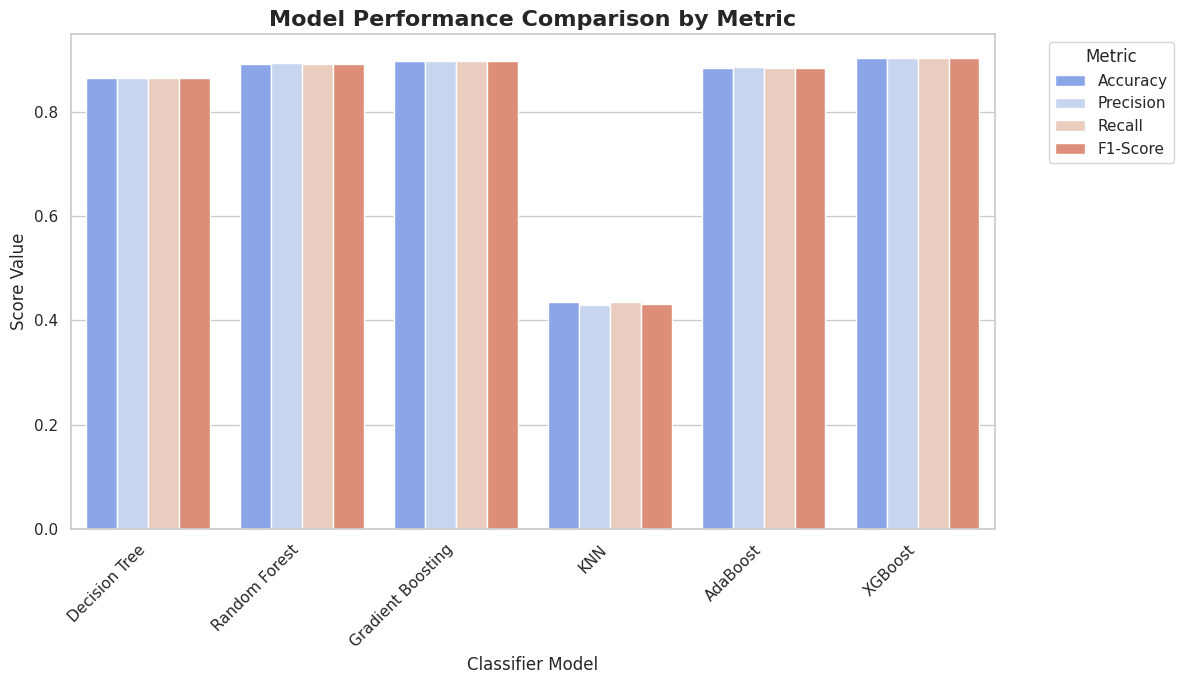

/tmp/ipython-input-3704210577.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Score', y='Model', data=results_ranked, palette='coolwarm')


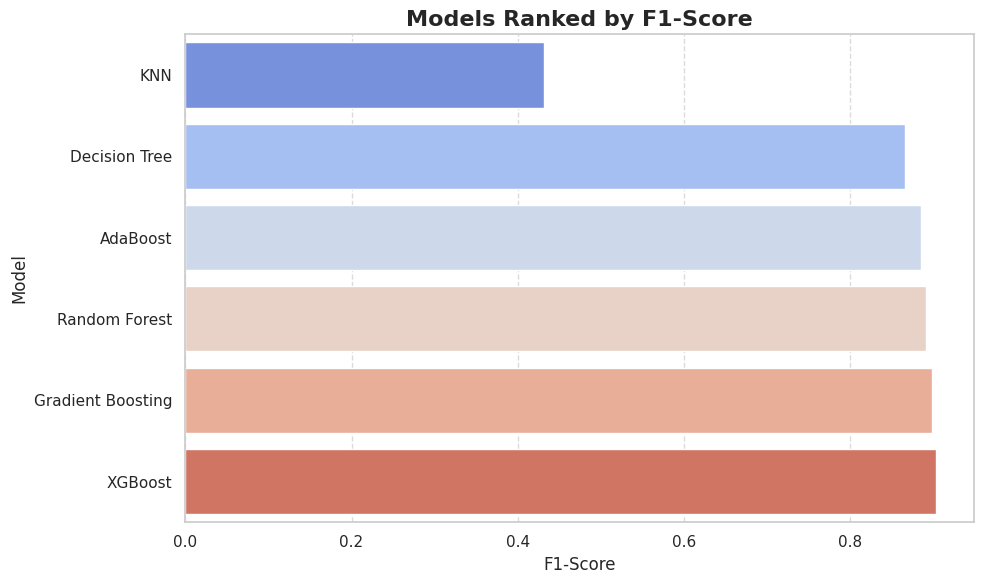

/tmp/ipython-input-3704210577.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_accuracy_ranked, palette='coolwarm')


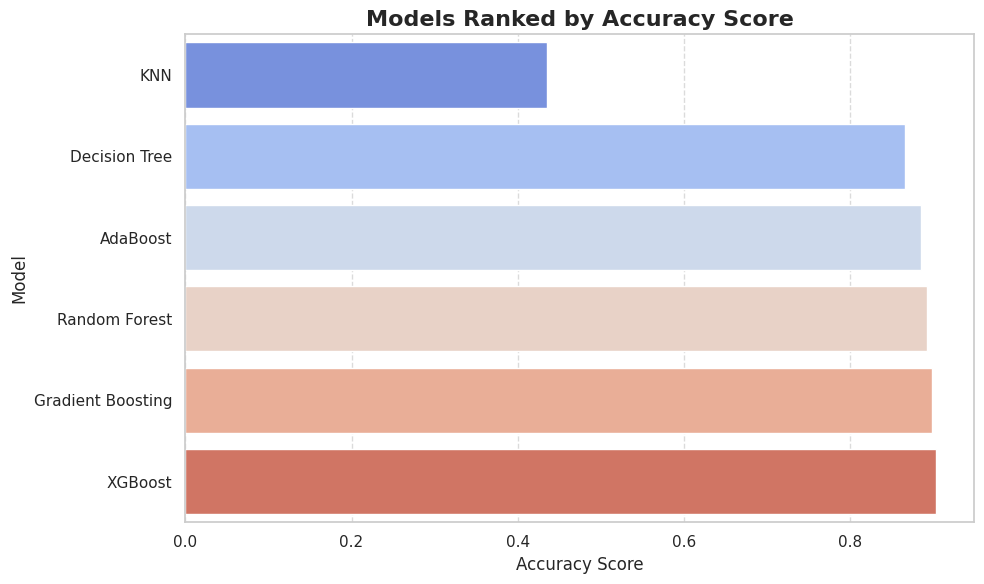

In [41]:
results = [
    {"Model": "Decision Tree",
     "Accuracy": test_accuracy_dtt,
     "Precision": test_precision_dtt,
     "Recall": test_recall_dtt,
     "F1-Score": test_f1_dtt},
    {"Model": "Random Forest",
     "Accuracy": test_accuracy_rf,
     "Precision": test_precision_rf,
     "Recall": test_recall_rf,
     "F1-Score": test_f1_rf},
    {"Model": "Gradient Boosting",
     "Accuracy": test_accuracy_gb,
     "Precision": test_precision_gb,
     "Recall": test_recall_gb,
     "F1-Score": test_f1_gb},
    {"Model": "KNN",
     "Accuracy": test_accuracy_knn,
     "Precision": test_precision_knn,
     "Recall": test_recall_knn,
     "F1-Score": test_f1_knn},
    {"Model": "AdaBoost",
     "Accuracy": test_accuracy_ab,
     "Precision": test_precision_ab,
     "Recall": test_recall_ab,
     "F1-Score": test_f1_ab},
    {"Model": "XGBoost",
     "Accuracy": test_accuracy_xgb,
     "Precision": test_precision_xgb,
     "Recall": test_recall_xgb,
     "F1-Score": test_f1_xgb},
]

results_df = pd.DataFrame(results).round(4)
# Display summary table
display(results_df)
display(results_df.set_index('Model').describe().round(4))

# Best model summary
best_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]
print(f" Best Overall Model (by F1-Score): *{best_model['Model']}* (F1-Score: {best_model['F1-Score']:.4f})")
print(f" Highest Accuracy Observed: {results_df['Accuracy'].max():.4f}")

# Melted for grouped metric comparison
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score', value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# 1. Grouped Metric Comparison – Swarmplot
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and palette
sns.set(style="whitegrid")
palette = sns.color_palette("coolwarm", n_colors=4)

# 1. Grouped bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted, palette=palette)

plt.title('Model Performance Comparison by Metric', fontsize=16, fontweight='bold')
plt.ylabel('Score Value', fontsize=12)
plt.xlabel('Classifier Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. F1-Score Ranking
results_ranked = results_df.sort_values(by='F1-Score', ascending=True)

# Horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='F1-Score', y='Model', data=results_ranked, palette='coolwarm')

plt.title('Models Ranked by F1-Score', fontsize=16, fontweight='bold')
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Accuracy Ranking –
results_accuracy_ranked = results_df.sort_values(by='Accuracy', ascending=True)

# BarPlot
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_accuracy_ranked, palette='coolwarm')

plt.title('Models Ranked by Accuracy Score', fontsize=16, fontweight='bold')
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.8713,0.8726,0.8713,0.8718
1,Random Forest,0.8970,0.8981,0.8970,0.8973
2,Gradient Boosting,0.8980,0.8982,0.8980,0.8981
3,KNN,0.5468,0.5414,0.5468,0.5415
4,AdaBoost,0.8937,0.8953,0.8937,0.8942
5,XGBoost,0.9511,0.9511,0.9511,0.9510


,Accuracy,Precision,Recall,F1-Score
count,6.0000,6.0000,6.0000,6.0000
mean,0.8430,0.8428,0.8430,0.8423
std,0.1475,0.1499,0.1475,0.1497
min,0.5468,0.5414,0.5468,0.5415
25%,0.8769,0.8783,0.8769,0.8774
50%,0.8954,0.8967,0.8954,0.8958
75%,0.8978,0.8982,0.8978,0.8979
max,0.9511,0.9511,0.9511,0.9510


 Best Overall Model (by F1-Score): *XGBoost* (F1-Score: 0.9510)
 Highest Accuracy Observed: 0.9511


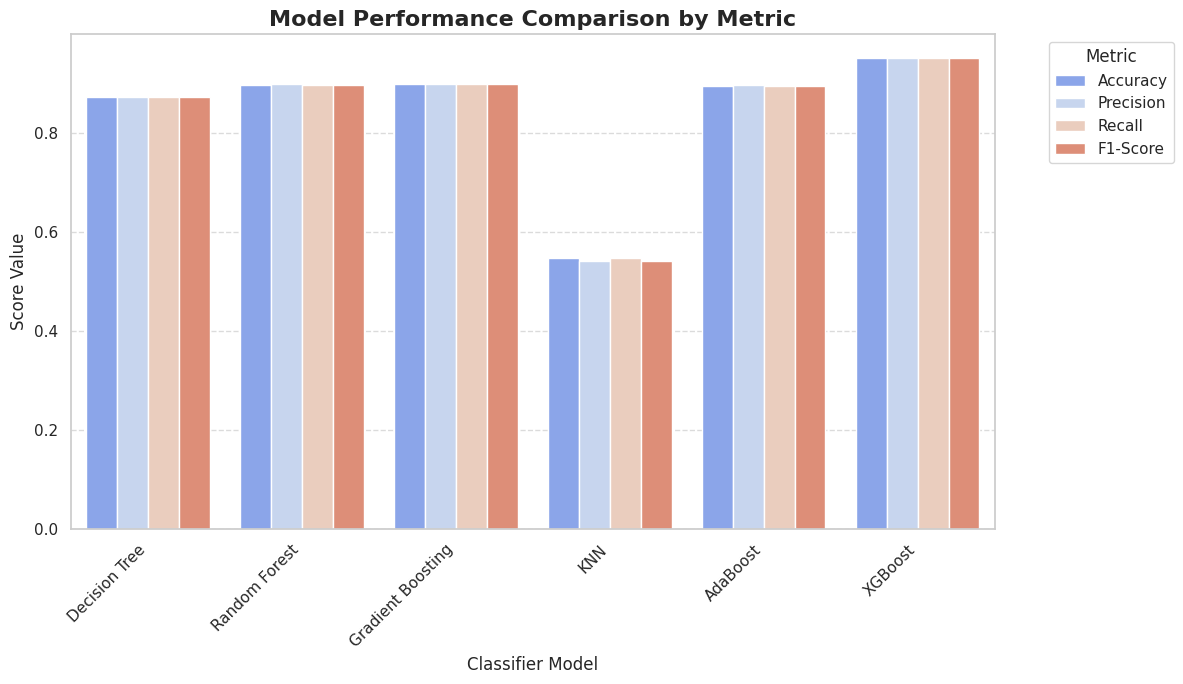

/tmp/ipython-input-2407063217.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_accuracy_ranked, palette='coolwarm')


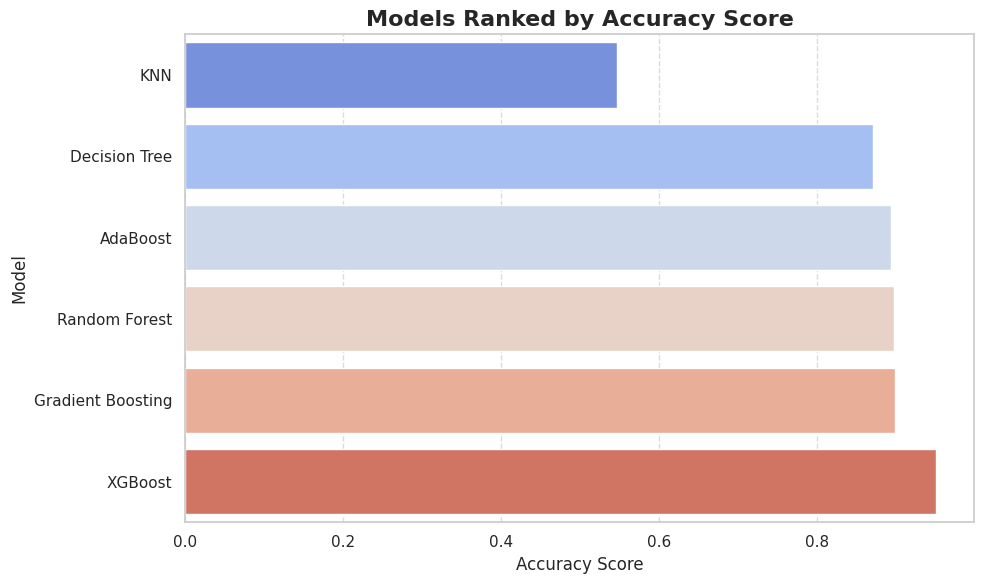

/tmp/ipython-input-2407063217.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Score', y='Model', data=results_ranked, palette='coolwarm')


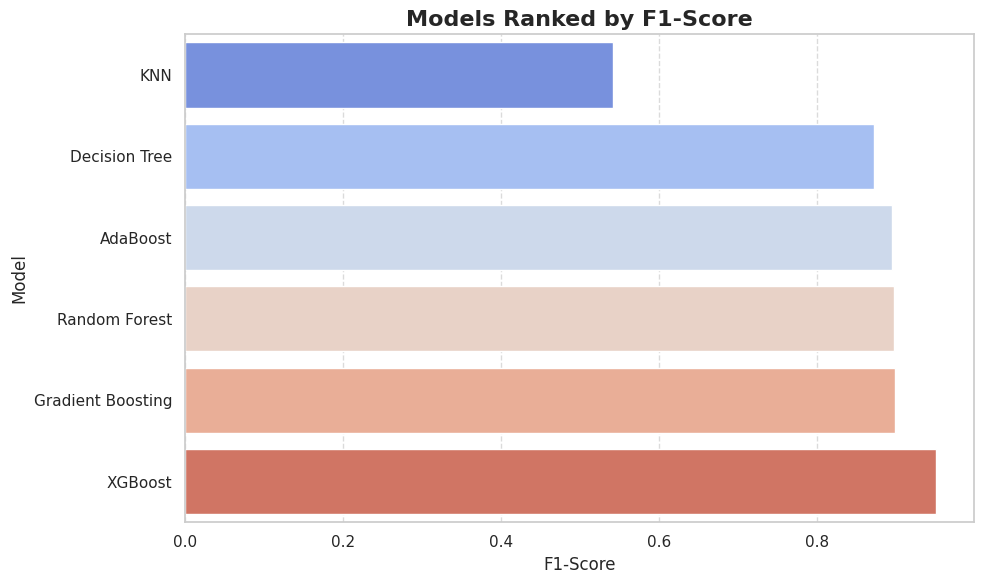

In [40]:
results = [
    {"Model": "Decision Tree",
     "Accuracy": test_accuracy_dtt_hp,
     "Precision": test_precision_dtt_hp,
     "Recall": test_recall_dtt_hp,
     "F1-Score": test_f1_dtt_hp},
    {"Model": "Random Forest",
     "Accuracy": test_accuracy_rf_hp,
     "Precision": test_precision_rf_hp,
     "Recall": test_recall_rf_hp,
     "F1-Score": test_f1_rf_hp},
    {"Model": "Gradient Boosting",
     "Accuracy": test_accuracy_gb,
     "Precision": test_precision_gb,
     "Recall": test_recall_gb,
     "F1-Score": test_f1_gb},
    {"Model": "KNN",
     "Accuracy": test_accuracy_knn_hp,
     "Precision": test_precision_knn_hp,
     "Recall": test_recall_knn_hp,
     "F1-Score": test_f1_knn_hp},
    {"Model": "AdaBoost",
     "Accuracy": test_accuracy_ab_hp,
     "Precision": test_precision_ab_hp,
     "Recall": test_recall_ab_hp,
     "F1-Score": test_f1_ab_hp},
    {"Model": "XGBoost",
     "Accuracy": test_accuracy_xgb_hp,
     "Precision": test_precision_xgb_hp,
     "Recall": test_recall_xgb_hp,
     "F1-Score": test_f1_xgb_hp},
]

results_df = pd.DataFrame(results).round(4)

# Display summary table
display(results_df)
display(results_df.set_index('Model').describe().round(4))

# Best model summary
best_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]
print(f" Best Overall Model (by F1-Score): *{best_model['Model']}* (F1-Score: {best_model['F1-Score']:.4f})")
print(f" Highest Accuracy Observed: {results_df['Accuracy'].max():.4f}")

# Melted for grouped metric comparison
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score', value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# 1. Grouped Metric Comparison – Swarmplot
plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted, palette='coolwarm')

plt.title('Model Performance Comparison by Metric', fontsize=16, fontweight='bold')
plt.ylabel('Score Value', fontsize=12)
plt.xlabel('Classifier Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# 2. Accuracy Ranking – Barplot
results_accuracy_ranked = results_df.sort_values(by='Accuracy', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_accuracy_ranked, palette='coolwarm')

plt.title('Models Ranked by Accuracy Score', fontsize=16, fontweight='bold')
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 3. F1-Score Ranking – Stripplot (Dotplot)
results_ranked = results_df.sort_values(by='F1-Score', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='F1-Score', y='Model', data=results_ranked, palette='coolwarm')

plt.title('Models Ranked by F1-Score', fontsize=16, fontweight='bold')
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

